In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
class Reaction:    
    def __init__(self,name,rate,reactants,products):   
        self.name=name
        self.rate=rate
        self.reactants=reactants    #[A,B]
        self.products=products      #[C,D]
        
        self.count={}   
        for sp in reactants:
            if sp in self.count:
                self.count[sp]-=1
            else:
                self.count[sp]=-1
        for sp in products:
            if sp in self.count:
                self.count[sp]+=1
            else:
                self.count[sp]=1
    
    def get_flux(self):        
        if callable(self.rate):
            return self.rate(self.reactants)    
        val=self.rate     #k=1.0
        for s in self.reactants:   
            val *=s.concentration       #v=k[a][b]...
        return val
    
    def __str__(self):   #こっちのみでok
        return str(self.name)+":"+'+'.join([str(r) for r in self.reactants])+"-->"+'+'.join([str(r) for r in  self.products])
    
    def __repr__(self):
        return str(self)

In [4]:
class Species:  #物質の定義
    def __init__(self,name,concentration,diffusion, parameter= None):   #コンストラクタ：インスタンス生成の際に必ず呼び出される。初期化
        self.name=name
        self.init_conc = concentration
        self._concentration=concentration #2d   
        self.diffusion=diffusion
        self.parameter = parameter
        self.relevant_enzymes = []
    
    @property    #関数を変数として扱える。中身いじらないように。
    def concentration(self):
        return self._concentration
    
    @concentration.setter   #propertyを外から変更できるようにする。
    def concentration(self,v):   #定義し直し
        self._concentration = v
        if len(self._concentration.shape) > 0:
            self._concentration[self._concentration < 0] = 0
        elif self._concentration < 0:
            #print(f"Concentration of {self.name} became 0")
            self._concentration = 0
        for e in self.relevant_enzymes:
            e.update_needed = True
        
    def __str__(self):    #print,str関数が呼び出されたらself.nameが返される。
        return self.name
    
    def __repr__(self):
        return str(self)
        

In [5]:
class Enzyme:
    def __init__(self, name, venz,Kenz):
        self.name = name
        self.venz = venz
        self.Kenz = Kenz #can be an array? Pol and Exo have multiple
        self.targets = {}
        self.update_needed = False
        self.sum = 0.0
        
    def register_target(self, species, Kval):
        self.targets[species] = Kval
        species.relevant_enzymes.append(self)
        self.update_needed = True
        
    def update_sum(self):
        self.sum = 0
        for s in self.targets:
            self.sum += s.concentration/self.targets[s]
        
    def activity(self, Kval):
        if self.update_needed:
            self.update_sum()
            self.update_needed = False
        return self.venz/(Kval*(1+self.sum))
    
    def rate(self, reactant, Kval):
        finalrate = self.activity(Kval)*reactant[0].concentration
        #print(f"Enzyme {self.name} rate versus {reactant[0].name} with conc {reactant[0].concentration}",finalrate)
        return finalrate

In [6]:
class Edge:
    
    def __init__(self,type_name, template, input, output, options={}): #vertices:頂点の集合,ege:矢印の集合？(辞書形)
        self.type=type_name
        self.template=template  #ネットワークの頂点  
        self.input = input
        self.output=output   #会合定数
        self.options=options
    
    
    

class ReactionFactory:   #ひな型
    
    #データを入れる領域 : コンストラクタ
    def __init__(self,name,vertices,kassoc = 0.2,extrastab=0.5, vpol=1050,vnick=80 ,vexo=300 
                 ,Kpol= 80, Kpolboth=5.5, Kpoldispl=5.0, Knick = 30,Kexos=440 ,Kexoext=150,Kselfstart=2000): #vertices:頂点の集合,ege:矢印の集合(辞書形)
        self.name=name
        self.vertices=vertices  #ネットワークの頂点
        self.id_num = 0
        self.kassoc = kassoc    #会合定数
        self.extrastab = extrastab #additional stability from being longer
        self.pol = Enzyme("pol",vpol,[Kpol,Kpolboth, Kselfstart])
        self.nick = Enzyme("nick",vnick,[Knick])
        self.exo = Enzyme("exo", vexo, [Kexos, Kexoext])
        
        
        #処理の仕方(メソッド=関数）を書く領域、自分のデータを参照できる
    def  get_reactions(self, edge):    #egeからproductを推測？
        if(edge==None):   #edeg=[]の時？
            return None
        
        all_reactions = []
        if edge.type == "PEN":    #Nの自己増殖反応（自己触媒）
            #TODO edge datatype: type, template, input (list), output(list)
            #intermediate species 中間種
            
            temp_alone = edge.template# not very clean, but easier to read?   
            temp_in = Species(edge.template.name+"_in",0,edge.template.diffusion)
            temp_out = Species(edge.template.name+"_out",0,edge.template.diffusion)
            temp_both = Species(edge.template.name+"_both",0,edge.template.diffusion)
            temp_ext = Species(edge.template.name+"_ext",0,edge.template.diffusion)
            int_species = [temp_in, temp_out,temp_both,temp_ext]  #テンプレートの進化系
            self.id_num += 1
            r1=Reaction(f"R{self.id_num}",self.kassoc,[edge.input[0],temp_alone],[temp_in])
            self.id_num += 1
            r2 = Reaction(f"R{self.id_num}",self.kassoc,[edge.output[0],temp_alone],[temp_out])
            self.id_num += 1
            r3 = Reaction(f"R{self.id_num}",self.kassoc,[edge.input[0],temp_out],[temp_both])
            self.id_num += 1
            r4 = Reaction(f"R{self.id_num}",self.kassoc,[edge.output[0],temp_in],[temp_both])
            self.id_num += 1
            # Backward reactions
            r5 = Reaction(f"R{self.id_num}",self.kassoc*edge.input[0].parameter,[temp_in],[edge.input[0],temp_alone])
            self.id_num += 1
            r6 = Reaction(f"R{self.id_num}",self.kassoc*edge.output[0].parameter,[temp_out],[edge.output[0],temp_alone])
            self.id_num += 1
            r7 = Reaction(f"R{self.id_num}",self.kassoc*edge.input[0].parameter,[temp_both],[edge.input[0],temp_out])
            self.id_num += 1
            r8 = Reaction(f"R{self.id_num}",self.kassoc*edge.output[0].parameter,[temp_both],[edge.output[0],temp_in])
            self.id_num += 1
           #Emzyme
            r9 = Reaction(f"R{self.id_num}",lambda reacts: self.pol.rate(reacts,self.pol.Kenz[0]),[temp_in],[temp_ext])
            self.pol.register_target(temp_in,self.pol.Kenz[0])
            self.id_num += 1
            r10 = Reaction(f"R{self.id_num}",lambda reacts: self.pol.rate(reacts,self.pol.Kenz[1]),[temp_both],[temp_ext,edge.output[0]])    
            self.pol.register_target(temp_out,self.pol.Kenz[1])
            self.id_num += 1
            r11 = Reaction(f"R{self.id_num}",lambda reacts: self.nick.rate(reacts,self.nick.Kenz[0]),[temp_ext],[temp_both])
            self.nick.register_target(temp_ext,self.nick.Kenz[0])
           
            
            all_reactions+=[r1,r2,r3,r4,r5,r6,r7,r8,r9,r10,r11]
            
            if "self-start" in edge.options:
                self.id_num += 1
                rmax= Reaction(f"R{self.id_num}",lambda reacts: 0.01*self.pol.rate(reacts,self.pol.Kenz[2]),[temp_alone],[temp_out])
                self.pol.register_target(temp_alone,self.pol.Kenz[2])
                all_reactions+=[rmax]
            
            if len(edge.input) > 1:   #③入力が2個以上の時inhibit??????
                #inhibitor　　　　   入力　出力をどう表現する？ inhubit=生成を妨げる
                #②inhibiterって例えば何？
                #TODO
                temp_inhib = Species(edge.template.name+"_inhib",0,edge.template.diffusion)
                int_species.append(temp_inhib)
                
                self.id_num += 1
                r12 = Reaction(f"R{self.id_num}",self.kassoc,[temp_in,edge.input[1]],[temp_inhib,edge.input[0]])
                self.id_num += 1
                r13 = Reaction(f"R{self.id_num}",self.kassoc,[temp_alone,edge.input[1]],[temp_inhib])
                self.id_num += 1
                r14 = Reaction(f"R{self.id_num}",self.kassoc,[temp_out,edge.input[1]],[temp_inhib,edge.output[0]])
                self.id_num += 1
                #TODO: reverse reactions
                
                r15= Reaction(f"R{self.id_num}",self.kassoc*edge.input[1].parameter/self.extrastab,[temp_inhib],[temp_alone,edge.input[1]])
                
               
                all_reactions+=[r12,r13,r14,r15]
        
        
       # ege=(PP,P,[N],[P]) 
        if edge.type == "PP":       #N+P->P+P input [N] output [P]
            #Nもspecies作った方がいいよね？
            pred_alone = edge.template  # P
            pred_in =Species(edge.template.name+"_in",0,edge.template.diffusion)   #change
            pred_ext = Species(edge.template.name+"_ext",0,edge.template.diffusion)   #change
            int_species = [ pred_in, pred_ext]  #テンプレートの進化系
            self.id_num += 1
            r1 = Reaction(f"R{self.id_num}",self.kassoc*pred_alone.parameter,[edge.input[0],pred_alone],[pred_in])   
            self.id_num += 1
            # Backward reactions
            r2 = Reaction(f"R{self.id_num}",self.kassoc*edge.input[0].parameter,[pred_in],[edge.input[0],pred_alone])   
            self.id_num += 1
            #PP->P+P
            r3= Reaction(f"R{self.id_num}",self.kassoc*pred_alone.parameter*self.extrastab,[pred_ext],[pred_alone,edge.output[0]])   #extra_stab:inverse of hybridazation
            
            #Enzyme
            self.id_num += 1
            r4= Reaction(f"R{self.id_num}",lambda reacts: self.pol.rate(reacts,self.pol.Kenz[0]),[pred_in],[pred_ext])
           # 
            
            all_reactions+=[r1,r2,r3,r4]
            
        if edge.type == "Exo":    
            #use "template" to define the type of degradation
            Kenz = self.exo.Kenz[0]
            if edge.template == "inhibitor":
                Kenz = self.exo.Kenz[1]
            self.id_num += 1
            r1= Reaction(f"R{self.id_num}",lambda reacts: self.exo.rate(reacts,Kenz),[edge.input[0]],[])  
            self.exo.register_target(edge.input[0],Kenz)
            int_species=[]
            all_reactions+=[r1]
            
        return int_species, all_reactions    #中間生成物、全ての反応
    
       
                
    
    def __str__(self):
        return str(self.name)+":"+'+'.join([str(v) for v in self.vertices])+"-->"+'+'.join([str(r) for r in get_product(self.ege)])
    #N+G->N+N+G


In [7]:
def get_total_rate(rate,reactants):   #反応物  rate:初期値                      
    if callable(rate):    #もしrateが呼び出し可能(=関数）なら                   
        return rate(reactants)    
    val=rate    #valは初期値                                                    
    for s in reactants:
        val*=s.concentration   #反応物の濃度を全てかける。                      
    return val

def mm_rate(reactants,saturators= None,Km=1.0,vmax=1.0): #ミカエリス・メンテ\ン式v=vmax*濃度/(Km+濃度 
    conc = np.product(np.array([reactant.concentration for reactant in reactants]),axis=0)             
    concsat = np.product(np.array([reactant.concentration for reactant in saturators]),axis=0) if saturators else conc   #後置if文 
    return vmax*conc/(Km+concsat)


In [8]:
def discrete_laplacian(M):    #二次元の時：拡散項に使用          
    """Get the discrete Laplacian of matrix M"""

    #変換                                                                       
    l=M.shape[0]+2    #(3,3)                                                    
    #print(l)                                                                   
    N=np.zeros((l,l))
    #print(N)                                                                   
    for i in range(l-2):
        for j in range(l-2):
            N[i+1,j+1]=M[i,j]
                                                                 
    L = -4*N
    L += np.roll(N, (0,-1), (0,1)) # right neighbor                             
    L += np.roll(N, (0,+1), (0,1)) # left neighbor                              
    L += np.roll(N, (-1,0), (0,1)) # top neighbor   
    L += np.roll(N, (+1,0), (0,1)) # bottom neighbor                            

                                                                         
    R=np.zeros(M.shape)
    for i in range(M.shape[0]):
        for j in range(M.shape[0]):
            R[i,j]=L[i+1,j+1]

    return R


In [9]:

def compute(t,y,species,reactions):                                                                     
    yprime = np.zeros(y.shape)  
    eq = {}
    for i,s in enumerate(species):      
        s.concentration = y[i]      
        eq[s.name] = i              
        # count if react with saturated enzyme (e.g. exo)
    for r in reactions:   #r1,r2,r3,r4
        flux = r.get_flux()     #速度v                                                                                        
        for s in r.count:   
            yprime[eq[s.name]] += r.count[s]*flux     
    if len(y.shape) > 1:
        yprime += np.array([species[i].diffusion*discrete_laplacian(v) for i, v in enumerate(y)])   #最後に拡散反応による変化  ここ要らない
    return yprime 

([G1_in, G1_out, G1_both, G1_ext, G1_inhib], [R1:N+G1-->G1_in, R2:N+G1-->G1_out, R3:N+G1_out-->G1_both, R4:N+G1_in-->G1_both, R5:G1_in-->N+G1, R6:G1_out-->N+G1, R7:G1_both-->N+G1_out, R8:G1_both-->N+G1_in, R9:G1_in-->G1_ext, R10:G1_both-->G1_ext+N, R11:G1_ext-->G1_both, R12:G1-->G1_out, R13:G1_in+I-->G1_inhib+N, R14:G1+I-->G1_inhib, R15:G1_out+I-->G1_inhib+N, R16:G1_inhib-->G1+I])


([G2_in, G2_out, G2_both, G2_ext], [R17:N+G2-->G2_in, R18:M+G2-->G2_out, R19:N+G2_out-->G2_both, R20:M+G2_in-->G2_both, R21:G2_in-->N+G2, R22:G2_out-->M+G2, R23:G2_both-->N+G2_out, R24:G2_both-->M+G2_in, R25:G2_in-->G2_ext, R26:G2_both-->G2_ext+M, R27:G2_ext-->G2_both])


([G3_in, G3_out, G3_both, G3_ext], [R28:M+G3-->G3_in, R29:I+G3-->G3_out, R30:M+G3_out-->G3_both, R31:I+G3_in-->G3_both, R32:G3_in-->M+G3, R33:G3_out-->I+G3, R34:G3_both-->M+G3_out, R35:G3_both-->I+G3_in, R36:G3_in-->G3_ext, R37:G3_both-->G3_ext+I, R38:G3_ext-->G3_both])


([], [R39:N-->])


([], [R40:M-->])


([], [R41:I-->])




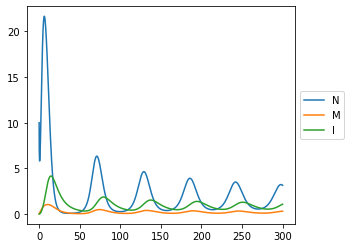

In [27]:
#Oligator
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
count=0   


                
G1 = Species("G1",10+1,1.0, 10.0)    #名前、濃度、拡散、パラメーター(安定
G2 = Species("G2",1,1.0, 10.0)
G3 = Species("G3",30,1.0, 10.0)
N= Species("N",10,2.0, 100.0)
M =  Species("M",0,2.0, 100.0)
I =  Species("I",0,2.0, 1.0)
I.inhibitor = "inhibitor"
#ここの数値を変える？
species = [N,M,I]
edge1=Edge("PEN", G1, [N,I], [N],options={"self-start": True})   #N->N自己触媒　　   input[0],input[1]
edge2 = Edge("PEN", G2, [N], [M])  #N->M N->Pも同じ？
edge3 = Edge("PEN", G3, [M], [I])
edges = [edge1,edge2,edge3]
for s in species:
    edges.append(Edge("Exo",s.inhibitor if hasattr(s,'inhibitor') else None,[s],[]))
species += [G1,G2,G3]
reactionfactory=ReactionFactory("Oligator",species)   #インスタンス変数
reactions = []
for edge in edges:
    all_gen = reactionfactory.get_reactions(edge)
    print(all_gen)
    species += all_gen[0]
    reactions += all_gen[1]
    print("\n")
args=( species, reactions)    #Species Reaction

res = solve_ivp(compute,[0,300],[s.init_conc for s in species],args=args)    #微分方程式をとく。関数f,t、初期値、Species Reaction?????
#solve_ivp(関数、時間、[A0、B0、C0、,,,](species,reactions))

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(res.t,(res.y[:3]).T)    #これはただこの関数を試しただけ  時間を横軸に。yって何？初期値？

#画像を保存
#タイトルにパラメータと一緒に保存
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend([s.name for s in species], loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("G1=11_G2=1_G3=10"+".png")
#振動するように変更する

([G1_in, G1_out, G1_both, G1_ext, G1_inhib], [R1:N+G1-->G1_in, R2:N+G1-->G1_out, R3:N+G1_out-->G1_both, R4:N+G1_in-->G1_both, R5:G1_in-->N+G1, R6:G1_out-->N+G1, R7:G1_both-->N+G1_out, R8:G1_both-->N+G1_in, R9:G1_in-->G1_ext, R10:G1_both-->G1_ext+N, R11:G1_ext-->G1_both, R12:G1_in+P1-->G1_inhib+N, R13:G1+P1-->G1_inhib, R14:G1_out+P1-->G1_inhib+N, R15:G1_inhib-->G1+P1])


([P2_in, P2_ext], [R16:N+P2-->P2_in, R17:P2_in-->N+P2, R18:P2_ext-->P2+P1, R19:P2_in-->P2_ext])


([], [R20:N-->])


([], [R21:P1-->])




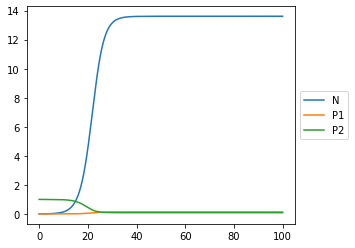

In [32]:
#b Bistable Switch
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

count=0   
fig, axs = plt.subplots(nrows=6, ncols=6, constrained_layout=True)  #グリッドの行・列


G1 = Species("G1",5,1.0, 10.0) 
N= Species("N",0.01,2.0, 100.0)    #濃度、拡散、安定性(stability)
P1=  Species("P1",0,2.0, 1.0)
P2=  Species("P2",1,2.0, 1.0)    
edge1=Edge("PEN",G1 , [N,P1], [N])   
edge2=Edge("PP", P2, [N], [P1])  
edges=[edge1,edge2]
species = [N,P1,P2]
for s in [N,P1]:
    edges.append(Edge("Exo",None,[s],[]))
species += [G1]

reactionfactory=ReactionFactory("Bistable　Switch",species)   #インスタンス変数
reactions = []
for edge in edges:
    all_gen = reactionfactory.get_reactions(edge)
    print(all_gen)
    species += all_gen[0]
    reactions += all_gen[1]
    print("\n")
args=( species, reactions)    #Species Reaction

res = solve_ivp(compute,[0,100],[s.init_conc for s in species],args=args)    #微分方程式をとく。関数f,t、初期値、Species Reaction
#solve_ivp(関数、時間、[A0、B0、C0、,,,](species,reactions))

fig = plt.figure
ax = plt.subplot(111)
ax.plot(res.t,(res.y[:3]).T)    #これはただこの関数を試しただけ  時間を横軸に。yって何？初期値？
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend([s.name for s in species], loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("Bistable:N=5_P2=1"+".png")

#画像を保存
  